In [2]:
# 1. 파이썬 코드에서 Matplotlib 폰트 설정
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import timedelta
from itertools import combinations
from collections import Counter

# 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정이 완료되었습니다.")

# 3. 데이터 로드 및 통합 (모든 문제 풀이의 시작점)
try:
    orders_df = pd.read_csv('../data/orders.csv')
    payments_df = pd.read_csv('../data/payments.csv')
    products_df = pd.read_csv('../data/products.csv')
    shipping_df = pd.read_csv('../data/shipping.csv')
    customers_df = pd.read_csv('../data/customers.csv')

    # 모든 데이터프레임 병합
    df = pd.merge(orders_df, payments_df, on='order_id', how='left')
    df = pd.merge(df, products_df, on='product_id', how='left')
    df = pd.merge(df, customers_df, on='customer_id', how='left')
    df = pd.merge(df, shipping_df, on='order_id', how='left')

    # 데이터 전처리
    date_cols = ['order_date', 'payment_date', 'join_date', 'shipping_start_date', 'shipping_end_date']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df['total_sales'] = df['quantity'] * df['price']
    
    print("데이터 로드 및 통합이 완료되었습니다.")

except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")


한글 폰트 설정이 완료되었습니다.
데이터 로드 및 통합이 완료되었습니다.


In [3]:
# 문제 2: 고객의 생애 가치(LTV)를 간단하게 계산하여 상위 10명의 고객을 찾으세요
# 비즈니스 목적: 장기적으로 회사에 가장 큰 가치를 제공하는 핵심 고객을 식별하고, 이들이게 차별화된 혜택을 제공하여 관계를 유지합니다

총 누적 구매액 기준 상위 10명 고객(LTV)
                 ltv
customer_id         
C0625        2894100
C1698        2761799
C1147        2756300
C1448        2463200
C1935        2422100
C0409        2245800
C1945        2227800
C0338        2221300
C1990        2207500
C0007        2200800


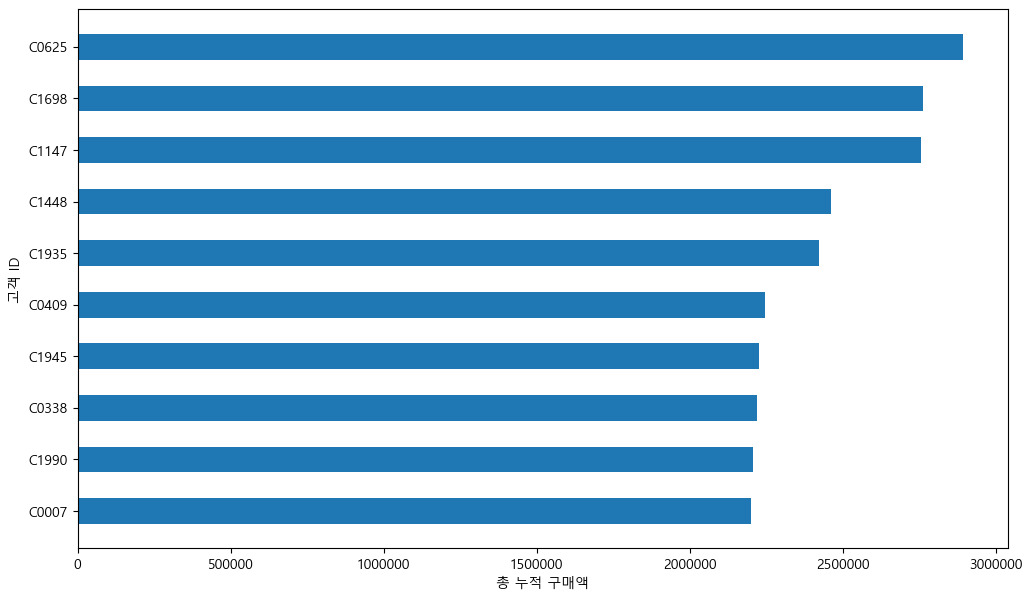

In [4]:
# 데이터 정제
import matplotlib.ticker as ticker

cols=['customer_id','order_id','total_sales','order_date']
df_data = df[cols].copy()

df_data = df_data.groupby('customer_id').agg(
    order_count=('order_id','count'),  # 주문 수
    total_revenue=('total_sales','sum'),  # 총 매출
    first_purchase=('order_date','min'),
    last_purchase=('order_date','max')
).reset_index()

df_data['lifespan_days'] = (df_data['last_purchase'] - df_data['first_purchase']).dt.days
df_data['lifespan_months'] = df_data['lifespan_days'] / 30
df_data['lifespan_months'] = df_data['lifespan_months'].replace(0, 1)  # 0 방지
# 평균 주문 금액 (AOV: Average Order Value)
df_data['avg_order_value'] = df_data['total_revenue'] / df_data['order_count']
# 구매 빈도 (월 평균 주문 수)
df_data['purchase_frequency'] = df_data['order_count'] / df_data['lifespan_months']
# LTV 계산
df_data['ltv'] = (df_data['avg_order_value'] * df_data['purchase_frequency'] * df_data['lifespan_months'])

pivot_df = pd.pivot_table(
    data=df_data,
    index='customer_id',
    values='ltv'
).astype(int)

top10_pivot = pivot_df.sort_values(by='ltv', ascending=False).head(10)

print('총 누적 구매액 기준 상위 10명 고객(LTV)')
print(top10_pivot)

plt.figure(figsize=(12,7))
plt.barh(top10_pivot.index, top10_pivot['ltv'],height=0.5)
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.gca().invert_yaxis()
plt.ylabel('고객 ID')
plt.xlabel('총 누적 구매액')
plt.show()

In [5]:
# 문제 3: 이탈 고객(가정: 마지막 구매 후 180일 이상 경과)의 이탈 직전 30일간 구매 패턴을 분석하세요.
# - 분석 기준일을 마지막 주문일 다음 날로 설정
# 비즈니스 목적: 고객이 이탈하기 전에 보이는 공통적인 행동 패턴을 파악하여, 유사한 패턴을 보이는 고객에게 선제적으로 이탈 방지 캠페인을 진행합니다. 

In [ ]:
# 데이터 전처리
cols=['customer_id','total_sales','order_date','category']
df_data = df[cols].copy()

last_order_date = df_data.groupby('customer_id').agg(last_order = ('order_date','max'))
last_order_date['reference_date'] = last_order_date['last_order'] + pd.Timedelta(days=1)
today = pd.Timestamp.today()
last_order_date['days_since_last_order'] = (today - last_order_date['reference_date']).dt.days
churned_customers = last_order_date[last_order_date['days_since_last_order'] >= 180].copy()
churned_customers['start_date'] = churned_customers['reference_date'] - pd.Timedelta(days=30)
df_merged = df_data.merge(churned_customers[['start_date', 'reference_date']], on='customer_id', how='inner')

# 이탈 직전 30일 내 구매만 필터링
recent_30days = df_merged[
    (df_merged['order_date'] >= df_merged['start_date']) &
    (df_merged['order_date'] <= df_merged['reference_date']) 
]
# 고객별 카테고리별 구매 건수
recent_30day = recent_30days.groupby(['customer_id', 'category'])['order_date'].count()

top5_cust = recent_30day.head(5)

customer_ids = top5_cust.index.get_level_values('customer_id').unique()

# 2. 해당 고객의 구매 이력 필터링
filtered = df_merged[df_merged['customer_id'].isin(customer_ids)]

customer_id
C0001    145842.857143
C0006    220500.000000
C0009    167366.666667
C0013    148875.000000
C0014    173440.000000
Name: total_sales, dtype: float64